# Continued Pre-training Foundation Models in Amazon Bedrock

> *This notebook has been tested to work with the **`SageMaker Distribution 1.3`** kernel in SageMaker Studio*

In this notebook, we will build the end-to-end workflow for continous pre-training and evaluating the Foundation Models (FMs) in Amazon Bedrock. 

- Prerequisite: Before running this notebook, please make sure you have created Bedrock Service role for customization jobs following [instructions on managing permissions for customization jobs](https://docs.aws.amazon.com/bedrock/latest/userguide/model-customization-iam-role.html)
- In this notebook we demonstrate using boto3 sdk for conintuous pre-training of the Amazon Titan Text model. You can also do this in the Bedrock console following the instructions [here](https://docs.aws.amazon.com/bedrock/latest/userguide/model-customization-console.html).

<div class="alert alert-block alert-warning">
<b>Warning:</b> This notebook will create provisioned throughput for testing the fine-tuned model. Therefore, please make sure to delete the provisioned throughput as mentioned in the last section of the notebook, otherwise you will be charged for it, even if you are not using it.
</div>

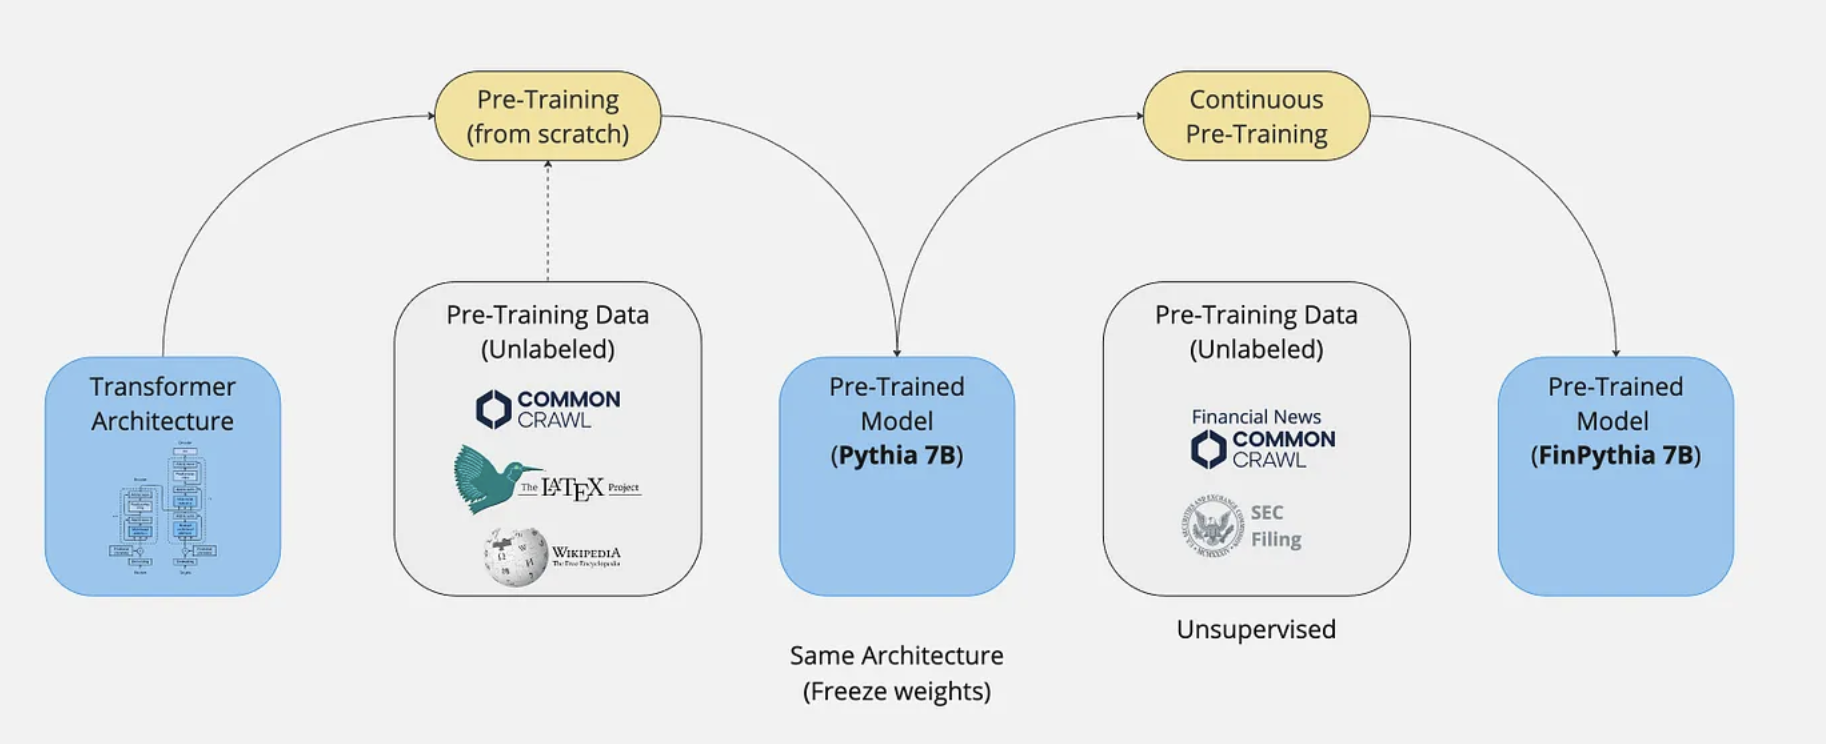

## Setup
Install and import all the needed libraries and dependencies to complete this notebook.

In [ ]:
!pip install --upgrade pip
!pip install -qU --force-reinstall boto3 langchain datasets typing_extensions pypdf

In [ ]:
!pip install ipywidgets

In [ ]:
!pip install jsonlines

In [ ]:
%store -r role_arn
%store -r bucket_name

In [ ]:
import warnings
import json
import os
import sys
import boto3
import logging
from botocore.exceptions import ClientError
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from urllib.request import urlretrieve
warnings.filterwarnings('ignore')
import random
import jsonlines

## Check the available models in Amazon Bedrock
Retrieve the modelId's available of base models for Continued Pre-training.

In [ ]:
bedrock = boto3.client(service_name="bedrock")
boto3_session = boto3.session.Session()
s3_client = boto3.client('s3')
sts_client = boto3.client('sts')
account_id = sts_client.get_caller_identity()["Account"]
region_name = boto3_session.region_name
s3_suffix = f"{region_name}-{account_id}"

print("s3 bucket name: ", bucket_name)

for model in bedrock.list_foundation_models(
    byCustomizationType="CONTINUED_PRE_TRAINING")["modelSummaries"]:
    print("-----------------------------------")
    print("{} -- {}".format(model["providerName"], model["modelName"]))
    print("-----------------------------------")
    for key, value in model.items():
        print(key, ":", value)
    print("\n")

## Preparing a Continued Pre-training dataset

To carry out Continued Pre-training on a text-to-text model, prepare a training and optional validation dataset by creating a JSONL file with multiple JSON lines. Because Continued Pre-training involves unlabeled data, each JSON line is a sample containing only an input field. Use 6 characters per token as an approximation for the number of tokens. The format is as follows.

    {"input": "<input text>"}
    
    {"input": "<input text>"}
    
    {"input": "<input text>"}      

The following is an example item that could be in the training data:
    
    {"input": "AWS stands for Amazon Web Services"}
    
See more guidance on how to [prepare your Bedrock continued pre-training dataset](https://docs.aws.amazon.com/bedrock/latest/userguide/model-customization-prereq.html). 

Once your Continued Pre-training dataset is ready, upload it to Amazon S3 and save the s3Uri to be used for creating a Continued Pre-training job. 

### Sample Dataset
Create a dataset using a PDF file.
Make sure that your dataset is propotional to the model. Since, the foundation models are big in size, continued pre-training will require bigger dataset. If you use a small dataset for example a PDF file with few pages, you will not be able to see significant difference in the model reponses.

For this workshop, we are using [`aws-cli user guide`](#https://docs.aws.amazon.com/pdfs/cli/latest/userguide/aws-cli.pdf#cli-services-s3).


#### Download the file

<div class="alert alert-block alert-info">
<b>Note:</b> Downloading the dataset will take about 20mins as dataset contains 5M rows and is 22.3 GB in size. However, for training the model we will only use a subset of the data.
</div>

In [ ]:
!mkdir data
url = 'https://docs.aws.amazon.com/pdfs/cli/latest/userguide/aws-cli.pdf'
file_name = "./data/aws-cli.pdf"
urlretrieve(url, file_name)

Please note the following [quotas for the continued pretraining](#https://docs.aws.amazon.com/bedrock/latest/userguide/quotas.html#model-customization-quotas) customization job. 

<table>
    <tr> <th>Description</th>	<th>Maximum (continued pre-training)</th>	<th>Adjustable</th> </tr>
    <tr> <td>Sum of input and output tokens when batch size is 2 </td><td>4,096</td><td>No</td> </tr>
    <tr> <td>Sum of input and output tokens when batch size is between 3 and 6</td><td>2,048</td><td>No</td> </tr>
    <tr><td>Character quota per sample in dataset</td>	<td>Token quota x 6</td>	<td>No</td> </tr>
    <tr><td>Training records in a dataset</td>	<td>100,000</td>	<td>Yes</td> </tr>
<tr><td>Validation records in a dataset</td>	<td>1,000</td> <td>Yes</td>
<tr><td>Training dataset file size</td><td>	10 GB</td> <td>Yes</td>
<tr><td>Validation dataset file size</td>	<td>100 MB</td>	<td>Yes</td>
</table>

Based on the above quotas, we will first load the pdf file, chunk it based on the above quotas, and transform into the format as needed for continued pre-training job.  
    
    {"input": "<input text>"}

#### Split the file text

In [ ]:
loader = PyPDFLoader(file_name)
document = loader.load()

In [ ]:
document[368].page_content

In [ ]:
# - in our testing Character split works better with this PDF data set
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 20000, # 4096 tokens * 6 chars per token = 24,576 
    chunk_overlap = 2000, # overlap for continuity across chunks
)

docs = text_splitter.split_documents(document)

#### Create the dataset file

In [ ]:
contents = ""
for doc in docs:
    content = {"input": doc.page_content}
    contents += (json.dumps(content) + "\n")

In [ ]:
dataset_folder = "data"
train_file_name = "aws-cli-dataset.jsonl"
train_dataset_filename = f"./{dataset_folder}/{train_file_name}"

with open(train_dataset_filename, "w") as file:
    file.writelines(contents)
    file.close()


#### Upload the file to your Amazon S3 bucket

In [ ]:
path = f'{dataset_folder}'
folder_name = "continued-pretraining" #Your folder name
# Upload data to s3
s3_client = boto3.client("s3")
s3_client.upload_file(f'{path}/{train_file_name}', bucket_name, f'{folder_name}/train/{train_file_name}')

In [ ]:
s3_train_uri=f's3://{bucket_name}/{folder_name}/train/{train_file_name}'
s3_train_uri

## Create the Continued Pre-training job
Now you have the dataset prepared and uploaded it is time to launch a new Continued Pre-training job. Complete the following fields required for the create_model_customization_job() API call. 

In [ ]:
from datetime import datetime
ts = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

# Select the foundation model you want to customize (you can find this from the "modelId" from listed foundation model list above)
base_model_id = "amazon.titan-text-lite-v1:0:4k"

# Select the "CONTINUED_PRE_TRAINING" customization type. 
customization_type = "CONTINUED_PRE_TRAINING"

# Specify the roleArn for your customization job
customization_role = role_arn

# Create a customization job name
customization_job_name = f"cpt-titan-lite-books-{ts}"

# Create a customized model name for your continued pre-trained model
custom_model_name = f"cpt-titan-lite-books-{ts}"

# Define the hyperparameters for continued pre-trained model
hyper_parameters = {
        "epochCount": "1",
        "batchSize": "1",
        "learningRate": "0.00005",
    }


# Specify your data path for training, validation(optional) and output
training_data_config = {"s3Uri": s3_train_uri}

'''
# REMOVE COMMENT IF YOU WANT TO USE A VALIDATION DATASET
validation_data_config = {
         "validators": [{
             # "name": "validation",
             "s3Uri": s3_validation_uri
         }]
     }
'''

output_data_config = {"s3Uri": "s3://{}/{}/output/".format(bucket_name, folder_name)}

# Create the customization job
bedrock.create_model_customization_job(
    customizationType=customization_type,
    jobName=customization_job_name,
    customModelName=custom_model_name,
    roleArn=customization_role,
    baseModelIdentifier=base_model_id,
    hyperParameters=hyper_parameters,
    trainingDataConfig=training_data_config,
    # validationDataConfig=validation_data_config,
    outputDataConfig=output_data_config
)

## Check Customization Job Status
Continued Pre-training a model will require some time. The following code will help you get the status of the training job. 

In [ ]:
training_job_status = bedrock.get_model_customization_job(jobIdentifier=customization_job_name)["status"]

In [ ]:
import time

while training_job_status == "InProgress":
    time.sleep(60)
    fine_tune_job = bedrock.get_model_customization_job(jobIdentifier=customization_job_name)["status"]
    print (training_job_status)

## Retrieve your customized model 
Once the customization job is Fisnihed, you can check your existing custom model(s) and retrieve the modelArn of your continually pre-trained model.

In [ ]:
# List your custom models
bedrock.list_custom_models()

In [ ]:
custom_model_arn = bedrock.get_custom_model(modelIdentifier=custom_model_name)['modelArn']
custom_model_arn

## Compare the customization output
Provision the customized model and compare the answer against the base model to evaluate the improvement

#### Provision the customized model

In [ ]:
bedrock_runtime = boto3.client(service_name="bedrock-runtime")

In [ ]:
import boto3
boto3.client(service_name='bedrock')
provisioned_model_id = bedrock.create_provisioned_model_throughput(
 modelUnits=1,
 provisionedModelName='custom_model_name', 
 modelId=bedrock.get_custom_model(modelIdentifier=custom_model_name)['modelArn']
)['provisionedModelArn']        

In [ ]:
status_provisioning = bedrock.get_provisioned_model_throughput(provisionedModelId = provisioned_model_id)['status']

In [ ]:
import time
while status_provisioning == 'Creating':
    time.sleep(60)
    status_provisioning = bedrock.get_provisioned_model_throughput(provisionedModelId=provisioned_model_id)['status']
    print(status_provisioning)

#### Define models to compare

In [ ]:
provider = "Amazon"

In [ ]:
for model in bedrock.list_foundation_models(
    byProvider=provider)["modelSummaries"]:
    print("-----------------------------------")
    print("{} -- {}".format(model["providerName"], model["modelName"]))
    print("-----------------------------------")
    for key, value in model.items():
        print(key, ":", value)
    print("\n")

In [ ]:
bedrock.list_provisioned_model_throughputs()

In [ ]:
provisioned_model_arn=bedrock.list_provisioned_model_throughputs()["provisionedModelSummaries"][0]["provisionedModelArn"]

In [ ]:
model_ids = [f"arn:aws:bedrock:{region_name}::foundation-model/amazon.titan-text-lite-v1", provisioned_model_arn] #Include your custom model and base models to test against

#### Compare outputs for all models

In [ ]:
def compare_model_outputs(model_ids, prompt):
    for model in model_ids:
        response = bedrock_runtime.invoke_model(
            modelId=model,
            body = json.dumps({
                "inputText": prompt,
                "textGenerationConfig": {
                    "maxTokenCount": 300,
                    "stopSequences": [],
                    "temperature": 0,
                    "topP": 0.3
                }
            })
        )
        response_body = json.loads(response.get("body").read())
        print("-----------------------------------")
        print(model)
        print(response_body["results"][0]["outputText"])
        print("-----------------------------------")

In [ ]:
prompt = """
Write aws-cli bash script to create a dynamoDB table. 
Do not repeat answer.
Do not add any preamble. 
"""

In [ ]:
compare_model_outputs(model_ids, prompt)

### Clean up resources

In [ ]:
bedrock.delete_provisioned_model_throughput(provisionedModelId=provisioned_model_id)